# IBM Data Science Capstone Project 

![alt text](https://raw.githubusercontent.com/thatjosh/IBM-Data-Science-Capstone-Project/master/Delivery_pic.PNG)

## Table of Contents

* 1.0 Introduction 
* 2.0 Importing Data Sets 
* 3.0 Exploratory Data Analysis 
* 4.0 K-means Clustering 
* 5.0 Analysing Each Cluster 

## 1.0 Introduction

### 1.1 Business Problem & Analysis Objective

In this project, we will hypothesise that a new food delivery company, like that of Uber Eats decides to expand to the city of Toronto in the midst of a COVID-19 lockdown. To ensure that every dollar is strategically spent, this food delivery company must selectively choose the most optimal regions for expansion in order to maintain a high gross profit margin. 

Problem Statement: This project seeks to determine the most strategic region in Toronto for a food delivery company to expand to. 

### 1.2 Data Requirements 

In this project, we will take into account of the supply of vendors and demand for delivery orders from customers to assess the potential of each region. Furthermore, the number of nearby restaurants within a 3km radius to a neighborhood is used to determine the number of potential vendors. On the other hand, the demand for delivery orders is assumed to be driven by purchasing power of each neighborhood's population. The purchasing power is both determined by population size and average household income.

#### Data Sources:
1. Nearby restaurants - [Foursquare](https://foursquare.com/)
2. Location data - [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
3. Demographic/ socioeconomic data (population size by neighbourhood, average after tax household income by neighbourhood) - [Wellbeing Toronto](http://map.toronto.ca/wellbeing/#eyJ0b3Itd2lkZ2V0LWNsYXNzYnJlYWsiOsSAcGVyY2VudE9wYWNpdHnElzcwfSwiY3VzxIJtYcSTYcSXxIBuZWlnaGJvdXJob29kc8S2fcSrxIHEg8SFxIfEicSLdGFixYXEmCLEo3RpdmVUxZBJZMSXxYnEhMWPYi1pbmRpY2HEgnLFhcWIYWdzTWFwxLYiesWCbcSXMTPErHjEly04ODM3NzYzLjXGhDcyN8SsxKc6NTQxMjkzMS4yNMaDMjg1xYjFpMWmxajFqsWSxIDFmMWraW9uxJcyxKxzxaRnbGXFhsSsxZZtZXPEm2nGtsayxK3Ev8STxJ9JxaXFp8WpxINNxYPGsToixq1uxq%2FGscWH)

### 1.3 Methodology

1. Various data sets were imported and subsequently combined into a single data frame.
2. Foursquare API is used to determine the number of the number of nearby restaurants within a 3km radius to a neighborhood, this is returned as restaurant count and appended to the combined dataframe.
3. To determine the most strategic location, neighbourhoods will be segregated into different regions via k-means clustering.
4. The statistical data on each region (or cluster) is then generated and explored.

## 2.0 Importing Data Sets

### 2.1 Toronto Borough and Neighborhood Data - Webscraping from Wikipedia, Appending Location Data 

In [1]:
# import relevant libraries

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

In [24]:
# webscrape data set - neighborhood data from Wikipedia

df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]
df = df[df.Borough!='Not assigned']
df.shape

(210, 3)

In [25]:
#copy df

toronto_df = df.copy()

# importing neighborhood coordinates & appending the data
location_coordinates = pd.read_csv (r'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
location_coordinates.rename(columns={'Postal Code': 'Postcode'}, inplace=True)

toronto_loc_data = pd.merge(toronto_df, location_coordinates, on='Postcode', how='inner')
toronto_loc_data.shape

(210, 5)

In [26]:
toronto_loc_data

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763
...,...,...,...,...,...
205,M8Z,Etobicoke,Kingsway Park South West,43.628841,-79.520999
206,M8Z,Etobicoke,Mimico NW,43.628841,-79.520999
207,M8Z,Etobicoke,The Queensway West,43.628841,-79.520999
208,M8Z,Etobicoke,Royal York South West,43.628841,-79.520999


### 2.2: Importing Household Income Data Set

In [27]:
# import household income of each Toronto neighbourhood

income_toronto_url = 'https://raw.githubusercontent.com/thatjosh/IBM-Data-Science-Capstone-Project/master/income_toronto.csv'
income_path = pd.read_csv(income_toronto_url)
df_income = pd.DataFrame(income_path)
df_income.drop(['Neighbourhood Id'], axis=1, inplace=True)
df_income.shape

(140, 2)

In [28]:
df_income

,Neighbourhood,After-Tax Household Income
0,West Humber-Clairville,59703.0
1,Mount Olive-Silverstone-Jamestown,46986.0
2,Thistletown-Beaumond Heights,57522.0
3,Rexdale-Kipling,51194.0
4,Elms-Old Rexdale,49425.0
...,...,...
135,West Hill,46803.0
136,Woburn,47908.0
137,Eglinton East,42790.0
138,Scarborough Village,40181.0


### 2.3: Importing Population Size Data Set

In [29]:
# load population of Southeast Asians in Toronto neighbourhoods

pop_toronto_url = 'https://raw.githubusercontent.com/thatjosh/IBM-Data-Science-Capstone-Project/master/population_toronto.csv'
pop_path = pd.read_csv(pop_toronto_url)
df_pop = pd.DataFrame(pop_path)
df_pop.drop(['Neighbourhood Id'], axis=1, inplace=True)
df_pop.shape

(140, 2)

In [30]:
df_pop

,Neighbourhood,Total Population
0,West Humber-Clairville,33312.0
1,Mount Olive-Silverstone-Jamestown,32954.0
2,Thistletown-Beaumond Heights,10360.0
3,Rexdale-Kipling,10529.0
4,Elms-Old Rexdale,9456.0
...,...,...
135,West Hill,27392.0
136,Woburn,53485.0
137,Eglinton East,22776.0
138,Scarborough Village,16724.0


### 2.4: Appending Data Sets

In [31]:
loc_stats = pd.merge(df_income, df_pop, on='Neighbourhood', how='inner')
final_loc_stats = pd.merge(loc_stats, toronto_loc_data, on='Neighbourhood', how='inner')
final_loc_stats.head(35)

,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude
0,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201
1,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321
2,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484
3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484
4,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963
5,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259
6,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259
7,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572
8,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923
9,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452


### 2.5: Foursquare to Count Number of Potential Vendors - Markland Wood

In [32]:
# include relevant details
CLIENT_ID = 'RKVAUDN2014ZXME2CXFJMUMNQLE1J4RS3H5DRYBCRSCFLQOW' # your Foursquare ID
CLIENT_SECRET = 'ME4IPSPL2KS0NKU232TJNP2I01HGEOWSTU3SBOBH5XKNAOCK' # your Foursquare Secret
ACCESS_TOKEN = 'OPEO55QB2L5VWCJTZNKCZAPDDJV4LWANNIGAGS3G1FSOZILE'
VERSION = '20180605' # Foursquare API version
LIMIT = 300 # A default Foursquare API limit value
categoryId = '4d4b7105d754a06374d81259'

# import relevant libraries
from pandas.io.json import json_normalize

In [33]:
# import location data from Forsquare

# other conditions
radius = 5000
search_query = 'Restaurant'


latitude = 43.643515
longitude = -79.577201

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT, categoryId)
url

'https://api.foursquare.com/v2/venues/search?client_id=RKVAUDN2014ZXME2CXFJMUMNQLE1J4RS3H5DRYBCRSCFLQOW&client_secret=ME4IPSPL2KS0NKU232TJNP2I01HGEOWSTU3SBOBH5XKNAOCK&ll=43.643515,-79.577201&oauth_token=OPEO55QB2L5VWCJTZNKCZAPDDJV4LWANNIGAGS3G1FSOZILE&v=20180605&query=Restaurant&radius=5000&limit=300'

In [34]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60cef23dd2fff22691315a8d'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4b533ffdf964a5201a9427e3',
    'name': 'Muddy Duck Restaurant',
    'location': {'address': '2200 Dundas St. E',
     'crossStreet': 'btw Regional Rd. 4 & Highway 407',
     'lat': 43.62597233051833,
     'lng': -79.56542718415807,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.62597233051833,
       'lng': -79.56542718415807}],
     'distance': 2171,
     'postalCode': 'L4X 2V3',
     'cc': 'CA',
     'neighborhood': 'Islington - City Centre West',
     'city': 'Mississauga',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['2200 Dundas St. E (btw Regional Rd. 4 & Highway 407)',
      'Mississauga ON L4X 2V3',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d14e941735',
      'name': 'American Restaurant',
      'pluralName': 'American Restaurants',
      'shortNa

In [35]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
MW_df = json_normalize(venues)
MW_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.neighborhood,location.city,location.state,location.country,location.formattedAddress,venuePage.id
0,4b533ffdf964a5201a9427e3,Muddy Duck Restaurant,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",v-1624175165,False,2200 Dundas St. E,btw Regional Rd. 4 & Highway 407,43.625972,-79.565427,"[{'label': 'display', 'lat': 43.62597233051833...",2171,L4X 2V3,CA,Islington - City Centre West,Mississauga,ON,Canada,[2200 Dundas St. E (btw Regional Rd. 4 & Highw...,NaN
1,534b2c4c498e3290a42bc2f1,Cross Eyed Bear Restaurant,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1624175165,False,555 Burnhamthorpe,The West Mall,43.644725,-79.568009,"[{'label': 'display', 'lat': 43.64472458866585...",752,M9C 2Y3,CA,NaN,Etobicoke,ON,Canada,"[555 Burnhamthorpe (The West Mall), Etobicoke ...",NaN
2,4bdf6678e75c0f470617cb03,Silk Road Restaurant 丝绸之路,"[{'id': '52af3b913cf9994f4e043c06', 'name': 'X...",v-1624175165,False,1852 Dundas St E,at Wharton Way,43.619278,-79.573031,"[{'label': 'display', 'lat': 43.61927817099883...",2718,L4X 1L9,CA,NaN,Mississauga,ON,Canada,"[1852 Dundas St E (at Wharton Way), Mississaug...",NaN
3,5dd098c5bf319f0008b5ba8d,Kahramana Restaurant,"[{'id': '5bae9231bedf3950379f89e7', 'name': 'I...",v-1624175165,False,3415 Dixie Road Unit 4A,NaN,43.617805,-79.595215,"[{'label': 'display', 'lat': 43.617805, 'lng':...",3209,L4Y 4J6,CA,NaN,Mississauga,ON,Canada,"[3415 Dixie Road Unit 4A, Mississauga ON L4Y 4...",NaN
4,4e8f1efebe7b11a0c4fd3f19,VAHALLA RESTAURANT,"[{'id': '4bf58dd8d48988d1c6941735', 'name': 'S...",v-1624175165,False,314 W Center Ave,NaN,43.640954,-79.564951,"[{'label': 'display', 'lat': 43.64095401822603...",1027,93291,CA,NaN,Vahalla,CA,Canada,"[314 W Center Ave, Vahalla CA 93291, Canada]",NaN


In [36]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in MW_df.columns if col.startswith('location.')] + ['id']
MW_df_filtered = MW_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
MW_df_filtered['categories'] = MW_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
MW_df_filtered.columns = [column.split('.')[-1] for column in MW_df_filtered.columns]

MW_df_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,id
0,Muddy Duck Restaurant,American Restaurant,2200 Dundas St. E,btw Regional Rd. 4 & Highway 407,43.625972,-79.565427,"[{'label': 'display', 'lat': 43.62597233051833...",2171,L4X 2V3,CA,Islington - City Centre West,Mississauga,ON,Canada,[2200 Dundas St. E (btw Regional Rd. 4 & Highw...,4b533ffdf964a5201a9427e3
1,Cross Eyed Bear Restaurant,Restaurant,555 Burnhamthorpe,The West Mall,43.644725,-79.568009,"[{'label': 'display', 'lat': 43.64472458866585...",752,M9C 2Y3,CA,NaN,Etobicoke,ON,Canada,"[555 Burnhamthorpe (The West Mall), Etobicoke ...",534b2c4c498e3290a42bc2f1
2,Silk Road Restaurant 丝绸之路,Xinjiang Restaurant,1852 Dundas St E,at Wharton Way,43.619278,-79.573031,"[{'label': 'display', 'lat': 43.61927817099883...",2718,L4X 1L9,CA,NaN,Mississauga,ON,Canada,"[1852 Dundas St E (at Wharton Way), Mississaug...",4bdf6678e75c0f470617cb03
3,Kahramana Restaurant,Iraqi Restaurant,3415 Dixie Road Unit 4A,NaN,43.617805,-79.595215,"[{'label': 'display', 'lat': 43.617805, 'lng':...",3209,L4Y 4J6,CA,NaN,Mississauga,ON,Canada,"[3415 Dixie Road Unit 4A, Mississauga ON L4Y 4...",5dd098c5bf319f0008b5ba8d
4,VAHALLA RESTAURANT,Scandinavian Restaurant,314 W Center Ave,NaN,43.640954,-79.564951,"[{'label': 'display', 'lat': 43.64095401822603...",1027,93291,CA,NaN,Vahalla,CA,Canada,"[314 W Center Ave, Vahalla CA 93291, Canada]",4e8f1efebe7b11a0c4fd3f19
5,Perkins Restaurant & Bakery,American Restaurant,600 Dixon Rd,at Martin Grove Rd,43.691977,-79.572811,"[{'label': 'display', 'lat': 43.69197748145365...",5406,M9W 1J1,CA,NaN,Toronto,ON,Canada,"[600 Dixon Rd (at Martin Grove Rd), Toronto ON...",4b80c40ef964a520e68a30e3
6,The Olive Restaurant,Restaurant,100 The East Mall,North Queen,43.619846,-79.549690,"[{'label': 'display', 'lat': 43.619846, 'lng':...",3443,M8Z 5X2,CA,Islington - City Centre West,Etobicoke,ON,Canada,"[100 The East Mall (North Queen), Etobicoke ON...",50b633dee4b0efc209002435
7,Restaurant Savana,American Restaurant,NaN,NaN,43.652166,-79.641770,"[{'label': 'display', 'lat': 43.65216594462269...",5289,NaN,CA,NaN,NaN,NaN,Canada,[Canada],4b9e3781f964a5208fd236e3
8,Best Friend Chinese Restaurant 老友記小廚,Chinese Restaurant,"888 Dundas St. E., Unit D1B",NaN,43.597756,-79.594227,"[{'label': 'display', 'lat': 43.59775555918656...",5275,L4Y 4G6,CA,NaN,Mississauga,ON,Canada,"[888 Dundas St. E., Unit D1B, Mississauga ON L...",4c3285c6a0ced13abf56156e
9,Golden Wok Chinese Restaurant,Chinese Restaurant,120 Eringate Dr. Unit #3,Renforth Dr,43.660491,-79.582319,"[{'label': 'display', 'lat': 43.66049068196177...",1934,M9C 3Z8,CA,NaN,Toronto,ON,Canada,"[120 Eringate Dr. Unit #3 (Renforth Dr), Toron...",4bfefc3b68c7a593dc004044


In [37]:
# count number of restaurants
len(MW_df_filtered[['name']].drop_duplicates())

50

### 2.6: Forsquare to Count Number of Potential Vendors - All Neighbourhoods

In [38]:
# generate neighbourhood list

neighbourhood_list = list(final_loc_stats['Neighbourhood'])
neighbourhood_list[3]

'Alderwood'

In [39]:
# import location data from Forsquare

# other conditions
radius = 3000
search_query = 'Restaurant'

# set global variable
i=0

# make list for restaurant count
count_restaurant = []


for x in neighbourhood_list:
    
    i
    latitude = final_loc_stats.iloc[i]['Latitude']
    longitude = final_loc_stats.iloc[i]['Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    i = i + 1
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    total_df = json_normalize(venues)
    total_df.head()
    
    count_restaurant.append(len(total_df[['name']].drop_duplicates()))
    print(len(total_df[['name']].drop_duplicates())) 


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:27: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


21
24
21
21
35
41
48
48
39
43
47
46
49
49
50
49
50
50
29
49
37
19
37
37
50
50
50
7
7
7
19
19
35
41
19


In [40]:
from pandas import DataFrame as df

count_restaurant_df = df(count_restaurant,columns=['Restaurant Count']) 

In [41]:
from pandas import DataFrame as df

final_loc_stats_2 = final_loc_stats

count_restaurant_df = df(count_restaurant,columns=['Restaurant Count']) 
final_loc_stats_2 = final_loc_stats_2.join(count_restaurant_df)
final_loc_stats_2

,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude,Restaurant Count
0,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201,21
1,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321,24
2,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484,21
3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484,21
4,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963,35
5,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259,41
6,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259,48
7,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572,48
8,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923,39
9,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452,43


## 3.0 Exploratory Data Analysis

### 3.1: Folium Mapping

In [42]:
# import relevant libraries
    # tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
import json

    # Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
    
    #folium
!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 7.6 MB/s  eta 0:00:01


In [43]:
map_Toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# copy df to prevent folium from changing the df
toronto_loc_f1 = final_loc_stats.copy()

# add markers to map
for lat, lng, borough, df_inner in zip(toronto_loc_f1['Latitude'], toronto_loc_f1['Longitude'], toronto_loc_f1['Borough'], toronto_loc_f1['Neighbourhood']):
    label = '{}, {}'.format(toronto_loc_f1, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [44]:
# import matplotlib

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### 3.2: Visualising (After Tax) Household Income 

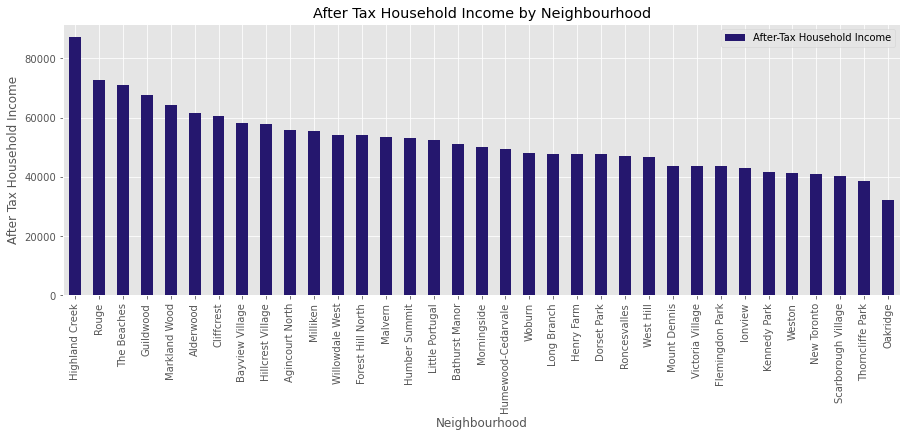

In [45]:
# define df
df_income = final_loc_stats_2[['Neighbourhood', 'After-Tax Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='After-Tax Household Income', ascending=False, inplace=True)

# plot
mpl.style.use('ggplot')
df_income.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('After Tax Household Income by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('After Tax Household Income')

plt.show()

In [46]:
df_income

,After-Tax Household Income
Neighbourhood,
Highland Creek,87321.0
Rouge,72784.0
The Beaches,70957.0
Guildwood,67678.0
Markland Wood,64297.0
Alderwood,61402.0
Cliffcrest,60384.0
Bayview Village,58028.0
Hillcrest Village,57682.0


### 3.3: Visualising Population

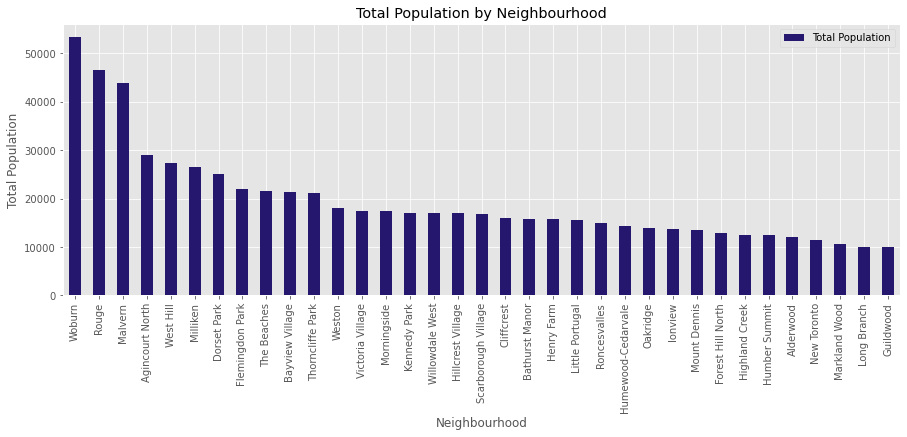

In [47]:
# define df
df_pop = final_loc_stats_2[['Neighbourhood', 'Total Population']].set_index('Neighbourhood')

# sort by descending order
df_pop.sort_values(by='Total Population', ascending=False, inplace=True)

# plot
mpl.style.use('ggplot')
df_pop.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('Total Population by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Total Population')

plt.show()

In [48]:
df_pop

,Total Population
Neighbourhood,
Woburn,53485.0
Rouge,46496.0
Malvern,43794.0
Agincourt North,29113.0
West Hill,27392.0
Milliken,26572.0
Dorset Park,25003.0
Flemingdon Park,21933.0
The Beaches,21567.0


### 3.4: Visualising Number of Potential Vendors

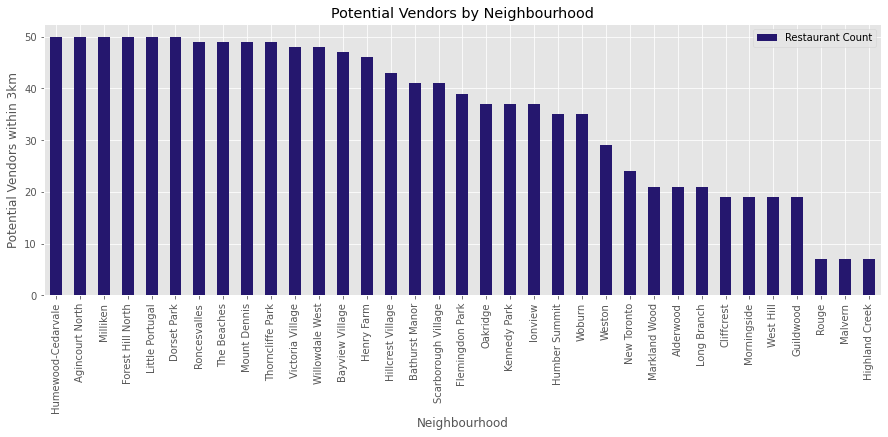

In [49]:
# define df
df_po_ven = final_loc_stats_2[['Neighbourhood', 'Restaurant Count']].set_index('Neighbourhood')

# sort by descending order
df_po_ven.sort_values(by='Restaurant Count', ascending=False, inplace=True)

# plot
mpl.style.use('ggplot')
df_po_ven.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('Potential Vendors by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Potential Vendors within 3km')

plt.show()

In [50]:
df_po_ven

,Restaurant Count
Neighbourhood,
Humewood-Cedarvale,50
Agincourt North,50
Milliken,50
Forest Hill North,50
Little Portugal,50
Dorset Park,50
Roncesvalles,49
The Beaches,49
Mount Dennis,49


## 4.0 K-means Clustering

### 4.1: Preparing Data Set - Normalising Each Category

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [52]:
final_loc_stats_2

,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude,Restaurant Count
0,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201,21
1,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321,24
2,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484,21
3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484,21
4,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963,35
5,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259,41
6,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259,48
7,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572,48
8,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923,39
9,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452,43


In [53]:
k=5
final_loc_stats_3 = final_loc_stats_2
cluster = final_loc_stats_3.drop(['Postcode', 'Borough', 'Neighbourhood','After-Tax Household Income','Total Population','Restaurant Count'], axis = 1)
cluster.rename(columns={0:'Household Income', 1:'Population Size', 2:'Latitude', 3: 'Longtitude', 4:'Restaurant Count'}, inplace=True)
cluster.head(5)

,Latitude,Longitude
0,43.643515,-79.577201
1,43.605647,-79.501321
2,43.602414,-79.543484
3,43.602414,-79.543484
4,43.756303,-79.565963


In [54]:
kmeans = KMeans(n_clusters = k,random_state=0).fit(cluster)
kmeans.labels_

Toronto_data = final_loc_stats_3
Toronto_data.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_data

,Cluster Labels,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude,Restaurant Count
0,3,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201,21
1,3,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321,24
2,3,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484,21
3,3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484,21
4,3,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963,35
5,0,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259,41
6,0,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259,48
7,2,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572,48
8,2,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923,39
9,4,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452,43


In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighbourhood'], Toronto_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4.2: Finding the Best Value for K

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytest-runner-5.3.0        |     pyhd3eb1b0_0          11 KB
    yellowbrick-1.3            |           py37_0         284 KB  districtdatalabs
    ------------------------------------------------------------
                                           Total:         294 KB

The following NEW packages will be INSTALLED:

  pytest-runner      pkgs/main/noarch::pytest-runner-5.3.0-pyhd3eb1b0_0
  yellowbrick        districtdatalabs/linux-64::yellowbrick-1.3-py37_0



yellowbrick-1.3      | 284 KB    | ##################################### | 100% 
pytest-runner-5.3.0  | 11 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transac

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


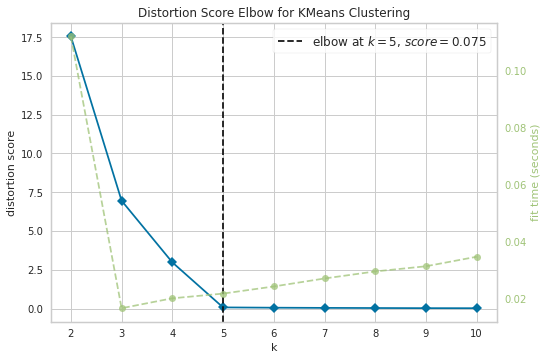

In [56]:
final_loc_stats_4 = final_loc_stats_2
cluster_2 = final_loc_stats_3.drop(['Postcode', 'Borough', 'Neighbourhood','After-Tax Household Income','Total Population','Restaurant Count'], axis = 1)
cluster_2.rename(columns={0:'Household Income', 1:'Population Size', 2:'Latitude', 3: 'Longtitude', 4:'Restaurant Count'}, inplace=True)

from sklearn.cluster import KMeans
!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualiser
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(cluster_2)        # Fit the data to the visualiser
visualizer.show()        # Finalise and render the figure

## 5.0 Analysing Each Cluster

### 5.1: Cluster 0

In [57]:
Tonronto_data_C0 = Toronto_data.drop(['Postcode', 'Borough'], axis = 1)
Tonronto_data_C0 = Tonronto_data_C0[Tonronto_data_C0["Cluster Labels"].isin([0])]
Tonronto_data_C0_mean = Tonronto_data_C0.mean()
Tonronto_data_C0_mean 

Cluster Labels                    0.000000
After-Tax Household Income    50246.285714
Total Population              14872.285714
Latitude                         43.702257
Longitude                       -79.439444
Restaurant Count                 48.142857
dtype: float64

In [58]:
stats_neighbourhood = pd.DataFrame (columns = ['Cluster Labels','After-Tax Household Income','Total Population', 'Latitude', 'Longitude', 'Restaurant Count'])

Tonronto_data_C = Toronto_data.drop(['Postcode', 'Borough'], axis = 1)
Tonronto_data_C0 = Tonronto_data_C[Tonronto_data_C["Cluster Labels"].isin([1])]
Toronto_data_C0_mean = Tonronto_data_C0.mean().to_frame().transpose()

stats_neighbourhood = stats_neighbourhood.append(Toronto_data_C0_mean, ignore_index = True)
stats_neighbourhood

,Cluster Labels,After-Tax Household Income,Total Population,Latitude,Longitude,Restaurant Count
0,1.0,58271.125,28469.625,43.775544,-79.196466,19.25


### 5.2: All Clusters

In [59]:
i = 0
stats_neighbourhood = pd.DataFrame (columns = ['Cluster Labels','After-Tax Household Income','Total Population', 'Latitude', 'Longitude', 'Restaurant Count'])

for x in range (0, 5):

    Tonronto_data_C = Toronto_data.drop(['Postcode','Borough'], axis = 1)
    Tonronto_data_C0 = Tonronto_data_C[Tonronto_data_C["Cluster Labels"].isin([i])]
    Toronto_data_C0_mean = Tonronto_data_C0.mean().to_frame().transpose()

    stats_neighbourhood = stats_neighbourhood.append(Toronto_data_C0_mean, ignore_index = True)
    i = i + 1

stats_neighbourhood

,Cluster Labels,After-Tax Household Income,Total Population,Latitude,Longitude,Restaurant Count
0,0.0,50246.285714,14872.285714,43.702257,-79.439444,48.142857
1,1.0,58271.125000,28469.625000,43.775544,-79.196466,19.250000
2,2.0,46855.111111,18629.444444,43.719356,-79.291146,40.555556
3,3.0,51477.666667,12427.166667,43.652861,-79.541607,25.166667
4,4.0,54945.200000,21947.600000,43.799946,-79.333027,47.200000


In [60]:
from sklearn import preprocessing

# drop non-variable columns 
stats_neighbourhood_norm = stats_neighbourhood.drop(['Cluster Labels','Latitude','Longitude', ], axis = 1)

x = stats_neighbourhood_norm.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalised = pd.DataFrame(x_scaled)
df_normalised

,0,1,2
0,0.297054,0.152415,1.000000
1,1.000000,1.000000,0.000000
2,0.000000,0.386616,0.737399
3,0.404919,0.000000,0.204780
4,0.708661,0.593452,0.967367


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


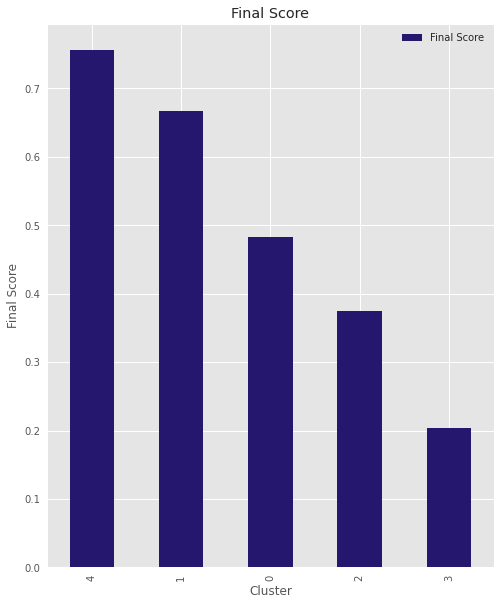

In [61]:
df_normalised_final = df_normalised.mean(axis=1).to_frame()
df_normalised_final .rename(columns={0:'Final Score'}, inplace=True)
df_normalised_final.sort_values(by='Final Score', ascending=False, inplace=True)

# plot graph
mpl.style.use('ggplot')
df_normalised_final.plot(kind='bar', figsize=(8,10), color='#25176e')
plt.title('Final Score')
plt.xlabel('Cluster')
plt.ylabel('Final Score')

plt.show()

In [62]:
df_normalised_final

,Final Score
4,0.756494
1,0.666667
0,0.483157
2,0.374672
3,0.203233
